In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score


import sys


import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

In [2]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = 'train2dof'
directory2 = '.'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if file.endswith("sensor1.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


In [3]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 5
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
#list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)


# RE-ARRANGEMENT OF TABULAR DATA INTO IMAGES

In [4]:
#arrange the data by 3, 4, 4

#arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


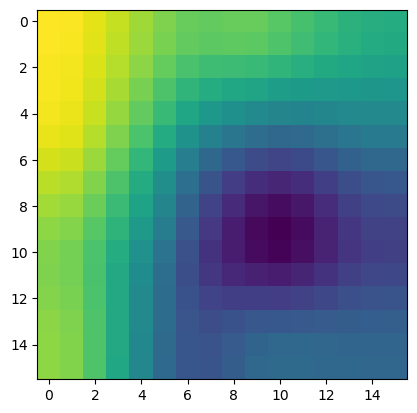

In [5]:
# FOR RESNET arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)

#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#Upscale each (4, 4) of x, y, z to (224, 224)
import cv2
up_size = 16
n_images = len(pd_x)

tac_imagex = np.zeros((n_images, up_size, up_size), np.float32)
tac_imagey = np.zeros((n_images, up_size, up_size), np.float32) 
tac_imagez = np.zeros((n_images, up_size, up_size), np.float32) 
#resize image to 3, up_size, up_size

for row in range(len(pd_x)):
    img_4_4_x = pd_x[row]
    tac_imagex[row] = cv2.resize(img_4_4_x.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

for row in range(len(pd_y)):
    img_4_4_y = pd_y[row]
    tac_imagey[row] = cv2.resize(img_4_4_y.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

for row in range(len(pd_z)):
    img_4_4_z = pd_z[row]
    tac_imagez[row] = cv2.resize(img_4_4_z.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

pd_main = [tac_imagex, tac_imagey, tac_imagez]

#arrange pd_main in a 3, 224, 224 array where its 3(224, 224) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, up_size, up_size))

#per row, get (224,224) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4

plt.imshow(tac_imagex[100040])
plt.show()

# CNN IMPLEMENTATION

In [6]:
# Upscale the image, Train, Get the shape, Form my dense layer

#Upscale the (4,4) part of the 3, 4, 4 image to 16, 16, 16,
import cv2

up_size = 16
n_images = len(pd_x)
tac_image = np.zeros((n_images, 3, up_size, up_size), np.float32) 
for row in range(n_images):

    #resize image to 3, up_size, up_size
    for channel in range(3):
        image_per_channel = pd_image[row][channel]
        tac_image[row][channel] = cv2.resize(image_per_channel.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)


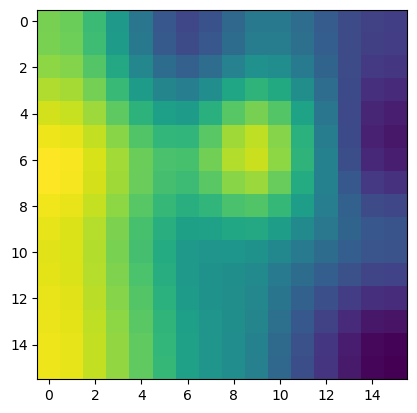

In [7]:
# Show scaled image
plt.imshow(tac_image[0][1])
plt.show()

In [8]:
#convert to tensor values
device = torch.device("mps")
tac_image = torch.from_numpy(tac_image.astype(np.float32)).to(device)
tac_label = torch.from_numpy(tac_label.astype(np.float32)).to(device)


In [9]:
#split the data into train and test
tac_image_train, tac_image_test, tac_label_train, tac_label_test = train_test_split(tac_image, tac_label, test_size=0.1, shuffle=True)

#split into train and validation
tac_image_train, tac_image_valid, tac_label_train, tac_label_valid = train_test_split(tac_image_train, tac_label_train, test_size=0.3, shuffle = True)


In [11]:
#Batch training for the data

class Batch_Taxels(Dataset):

    def __init__(self, tac_image_train, tac_label_train, tac_image_valid, tac_label_valid, valid = None):
        self.x = tac_image_train
        self.y = tac_label_train
        self.xvalid = tac_image_valid
        self.yvalid = tac_label_valid
        self.valid = valid

    def __len__(self):
        if self.valid == True:
            return self.xvalid.shape[0]
        else:
            return self.x.shape[0]

    def __getitem__(self, idx):

        if self.valid == True:
            return self.xvalid[idx], self.yvalid[idx]
        else:
            return self.x[idx], self.y[idx]

#Divide the data into batches
dataset = Batch_Taxels(tac_image_train, tac_label_train, tac_image_valid, tac_label_valid)
dataset2 = Batch_Taxels(tac_image_train, tac_label_train, tac_image_valid, tac_label_valid, valid = True)

xelaloader = DataLoader(dataset = dataset, batch_size=32, shuffle=True)
xelaloadervalid = DataLoader(dataset = dataset2, batch_size=32, shuffle=True)

In [12]:
class CNN(nn.Module):

    def __init__(self, in_channels=3, num_classes=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        #print(x.shape) 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) #apply droupout in the layer
        x = torch.sigmoid(self.fc3(x))
        return x

       
       
    

In [14]:
#Training and validation loop 

num_epochs = 10
learning_rate  = 0.0001
model = CNN().to(device)

# Loss and optimizer
loss = nn.BCELoss()#pos_weight=torch.tensor([2.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
valid_loss = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

t_acc_t = []
v_acc_t = []

for epoch in range(num_epochs):
    #Train per batch
    
    total = 0
    correct = 0
    l_xelaloader = 0

    model.train()
    for (x, y) in (xelaloader):

        #Forward pass
        y_pred = model(x.to(device))
       
        #compute the loss
        l = loss(y_pred, y.to(device))

        #empty the gradients
        optimizer.zero_grad()

        #compute the gradient
        l.backward()

        #update the weights
        optimizer.step()


        #append each loss per batch
        train_loss.append(l.item())

        #accuracy
        total += y.size(0)
        correct += y_pred.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
        
    
    t_acc = correct/l_xelaloader
    t_acc_t.append(t_acc)

    total = 0
    correct = 0
    l_xelaloader = 0

    #calculate and plot the validation loss
    model.eval()
    for (x,y) in (xelaloadervalid):
        y_pred_test = model(x.to(device))
        lv = loss(y_pred_test, y.to(device))
        #append the loss per batch
        valid_loss.append(lv.item())

        #accuracy
        total += y.size(0)
        correct += y_pred_test.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
        
    v_acc = correct/l_xelaloader
    v_acc_t.append(v_acc)

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))

    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )

For training epoch 1, loss =0.15077913 For validation epoch 1, loss =0.06868427
For training epoch 2, loss =0.00017326 For validation epoch 2, loss =0.01943398
For training epoch 3, loss =0.00027344 For validation epoch 3, loss =0.00858050
For training epoch 4, loss =0.19795187 For validation epoch 4, loss =0.03617001
For training epoch 5, loss =0.00702250 For validation epoch 5, loss =0.04859103
For training epoch 6, loss =0.10546459 For validation epoch 6, loss =0.00211844
For training epoch 7, loss =0.00000022 For validation epoch 7, loss =0.00000439
For training epoch 8, loss =0.00000067 For validation epoch 8, loss =0.00633113
For training epoch 9, loss =0.00944106 For validation epoch 9, loss =0.02957547
For training epoch 10, loss =0.00323733 For validation epoch 10, loss =0.00978028


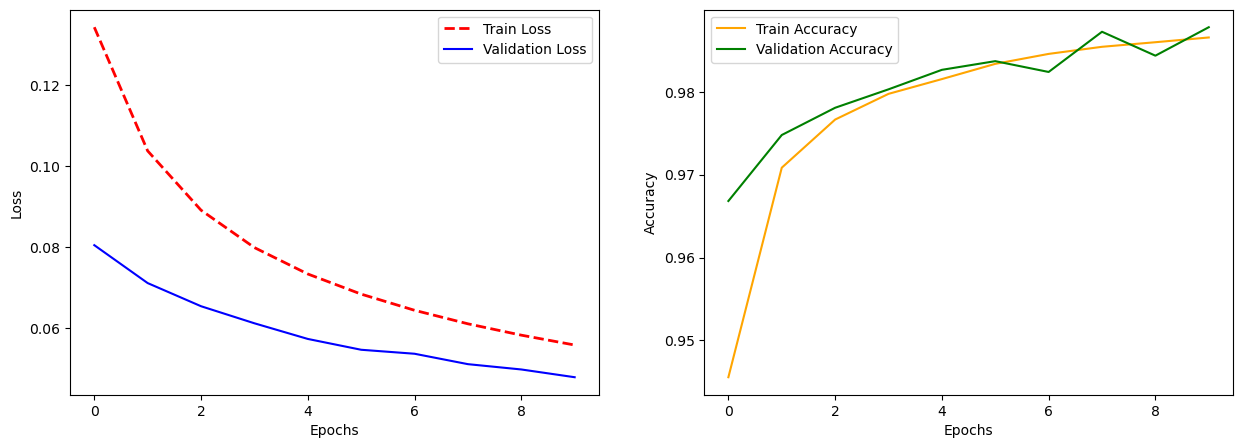

In [16]:
#Plot the loss per epoch for training and validation for CNN

fig, ax = plt.subplots(1,2,figsize=(15,5))

#set labels
ax[0].set_xlabel('Epochs', color = 'black')
ax[0].set_ylabel('Loss', color = 'black')
ax[1].set_xlabel('Epochs', color = 'black')
ax[1].set_ylabel('Accuracy', color = 'black')


ax[0].plot(t_loss, label='Train Loss', color='red', linewidth=2, linestyle='dashed')
ax[0].plot(v_loss, label='Validation Loss', color = 'blue')
ax[1].plot(t_acc_t, label = 'Train Accuracy', color = 'orange')
ax[1].plot(v_acc_t, label = 'Validation Accuracy', color = 'green')

#set legends
ax[0].legend()
ax[1].legend()


In [19]:
# save model
torch.save(model.state_dict(), "cnn_model_15_05_25.pth")

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [22]:
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [56]:
input_tensor = tac_image[54].unsqueeze(0).to(device)  # Add batch dimension
target_layers = [model.conv2]
cam = GradCAM(model=model, target_layers=target_layers)
target = None
grayscale_cam = cam(input_tensor=input_tensor, targets=target)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(input_tensor.squeeze(), grayscale_cam, use_rgb=True)

In [53]:
grayscale_cam.shape

(1, 16, 16)

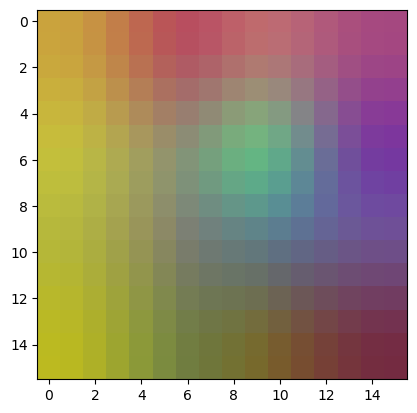

In [57]:
plt.imshow(input_tensor.cpu().squeeze().permute(1, 2, 0).numpy())

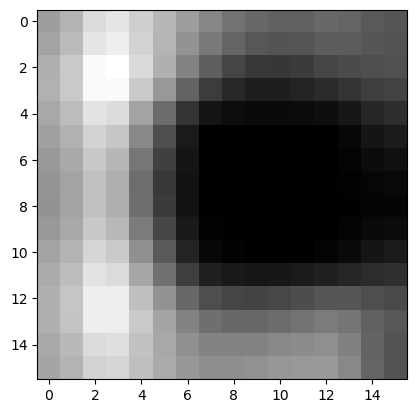

In [ ]:
plt.imshow(grayscale_cam.squeeze(), cmap='gray')

# Other Metrics

In [17]:
#Metrics definition
def detection_metrics(xela_test, sliplabel_test, model_type):
    #predict using the holdout set (DONE)
    predicted = model_type(xela_test).detach()#.numpy()
    _, predicted_cls = predicted.max(1)
    predicted_cls = predicted_cls.numpy().round()

    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    x = 0
    for i in range(predicted_cls.shape[0]):
        if predicted_cls[i].item() == sliplabel_test[i].item():
            x += 1

    accuracy = x/ float(sliplabel_test.shape[0])
    print(f'Accuracy for slip detection is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Fscore for slip detection is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Precision for slip detection is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Recall for slip detection is {recall}')

def slip_metrics(xela_test, sliplabel_test, modeltype):
    #predict using the holdout set (DONE)
    predicted = modeltype(xela_test).detach()#.numpy()
    _, predicted_cls = predicted.max(1)
    predicted_cls = predicted_cls.numpy().round()
    
    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    x = 0
    for i in range(predicted_cls.shape[0]):
        if predicted_cls[i].item() == sliplabel_test[i].item():
            x += 1

    accuracy = x/ float(sliplabel_test.shape[0])
    print(f'Accuracy for slip prediction for (t+{n}) is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Fscore for slip prediction for (t+{n}) is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Precision for slip prediction for (t+{n}) is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Recall for slip prediction for (t+{n}) is {recall}')



In [18]:
#print metrics
detection_metrics(tac_image_test, tac_label_test, model)
slip_metrics(tac_image_test, tac_label_test, model)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# RESNET IMPLEMENTATION


In [ ]:
# upscale from 4,4 to 224, 244, then, reshae x, y, z to 3, 224, 224



In [ ]:
tac_image.shape, tac_label.shape, tac_image_train.shape, tac_label_train.shape, tac_image_valid.shape, tac_label_valid.shape

In [ ]:
plt.imshow(tac_image_train[0][0])

In [ ]:
#create the batch training class for the model
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

composed = torchvision.transforms.Compose ([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

class tactile_resnet(Dataset):
    def __init__(self, tac_image, tac_label, transform = None):
        self.x = tac_image
        self.y = tac_label
        self.transform = transform
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample


data_set_train = tactile_resnet(tac_image_train, tac_label_train, transform = None)
data_set_valid = tactile_resnet(tac_image_valid, tac_label_valid, transform = None)

dataloader_train = DataLoader(dataset = data_set_train, batch_size = 32, shuffle = True )
dataloader_valid = DataLoader(dataset = data_set_valid, batch_size = 32, shuffle = True )

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    valid_loss = []

    t_loss = []
    v_loss = []

    t_acc = []
    v_acc = []

    t_acc_t = []
    v_acc_t = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        total = 0
        correct = 0
        l_xelaloader = 0

        #Training
        for inputs, labels in dataloader_train:
            model.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            #empty the gradients
            optimizer.zero_grad()

            t = time.time()
            #Forward pass
            outputs = model(inputs)

            print(time.time() - t)
            #compute the loss
            l = criterion(outputs, labels)

            #apply softmax to the output
            _, preds = torch.max(outputs, 1)

            #compute the gradient
            l.backward()

            #update the weights
            optimizer.step()

            scheduler.step()
            #append each loss per batch
            train_loss.append(l.item())

            #accuracy
            total += labels.size(0)
            correct += outputs.round().eq(labels).sum().item()
            l_xelaloader += inputs.shape[0]
        
    
        t_acc = correct/l_xelaloader
        t_acc_t.append(t_acc)

        total = 0
        correct = 0
        l_xelaloader = 0
        
        #append the total training loss and accuracy per epoch
        t_loss.append(np.mean(train_loss))

        #validation
        model.eval()
        for inputs, labels in dataloader_valid:
            outputs_valid = model(inputs)
            lv = criterion(outputs_valid, labels)

            _, preds = torch.max(outputs_valid, 1)

                #append each loss per batch
            valid_loss.append(lv.item())

            total += labels.size(0)
            correct += outputs.round().eq(labels).sum().item()
            l_xelaloader += inputs.shape[0]
    
        v_acc = correct/l_xelaloader
        v_acc_t.append(v_acc)
            # deep copy the model
        if t_acc > best_acc:
            best_acc = t_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        #Metrics
        #append the total validation loss and accuracy per epoch
        v_loss.append(np.mean(valid_loss))

        
    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

#create the new fully connected layer of the model
model.fc = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

#print(model)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 1)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

# RNN & LSTM IMPLEMENTATION

In [ ]:
for x, y in xelaloader:
    print (x.shape, y.shape)
    break

In [ ]:
inputsize = 2 # 2 => 16*16 as 2D
seq_length = 3 # 3 => unroll for x, y, z
num_layers = 2 
hidden_size = 2
learning_rate = 0.001
num_epochs = 10

class RNN(nn.Module):
    def __init__(self, inputsize, hidden_size, num_layers, num_classes = 1):
        super (RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(inputsize, hidden_size, num_layers, batch_first = True)

        self.fc  = nn.Linear(hidden_size*seq_length, num_classes)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.shape[0], inputsize)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
        


In [ ]:
#Training and validation loop 
model = RNN(inputsize, hidden_size, num_layers, num_classes = 1)

# Loss and optimizer
loss = nn.BCELoss()#pos_weight=torch.tensor([2.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
valid_loss = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

t_acc_t = []
v_acc_t = []

for epoch in range(num_epochs):
    #Train per batch
    
    total = 0
    correct = 0
    l_xelaloader = 0

    model.train()
    for (x, y) in (xelaloader):

        #Forward pass
        y_pred = model(x)
       
        #compute the loss
        l = loss(y_pred, y)

        #empty the gradients
        optimizer.zero_grad()

        #compute the gradient
        l.backward()

        #update the weights
        optimizer.step()


        #append each loss per batch
        train_loss.append(l.item())

        #accuracy
        total += y.size(0)
        correct += y_pred.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
        
    
    t_acc = correct/l_xelaloader
    t_acc_t.append(t_acc)

    total = 0
    correct = 0
    l_xelaloader = 0

    #calculate and plot the validation loss
    model.eval()
    for (x,y) in (xelaloadervalid):
        y_pred_test = model(x)
        lv = loss(y_pred_test, y)
        #append the loss per batch
        valid_loss.append(lv.item())

        #accuracy
        total += y.size(0)
        correct += y_pred_test.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
        
    v_acc = correct/l_xelaloader
    v_acc_t.append(v_acc)

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))

    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )